In [84]:
import numpy as np
from skimage import data, color, io, exposure, transform
import matplotlib.pyplot as plt
from skimage.filters import roberts
from skimage.transform import rescale, resize
import os
import pandas as pd

# 1: Predicting the class label of the query image using the K-Nearest Neighbors(k=15)

In [26]:
path = 'Projects/LFC/CSCI-450/jpg'
imagelist = sorted(os.listdir(path))
len(imagelist)

8189

In [27]:
# This is to eliminate the 'Thumbs.db' filename from the list
if imagelist[-1]=='Thumbs.db':
    imagelist = imagelist[:-1]
len(imagelist)

8189

In [28]:
def manhattanDistance(a,b):
    a = np.array(a)
    b = np.array(b)
    return np.sum(np.abs(a-b))

In [29]:
#normalization 
def imNormalize(image):
    if len(image.shape)==2: #height, width
        r = image
        g = image
        b = image
    else:
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
    
    r = r - r.min() #min is 0
    r = r / r.max() #max is 1; brightetst pixel is 1
    r = np.uint8(r * 255) #makes 0-255
    
    g = g - g.min()
    g = g / g.max()
    g = np.uint8(g * 255)
    
    b = b - b.min()
    b = b / b.max()
    b = np.uint8(b * 255)
    
    return np.stack((r,g,b),axis=2) 


In [30]:
#HSV histogram
def colorHistogramHSV(image): 
    image = imNormalize(image)
    image = color.rgb2hsv(image)
    
    h1 = exposure.histogram(image[:,:,0])
    h2 = exposure.histogram(image[:,:,1])
    h3 = exposure.histogram(image[:,:,2])
    h = np.concatenate((h1[0],h2[0],h3[0]), axis = None) 
    
    h = h / (image.shape[0]*image.shape[1]) 
    return h 

In [31]:
featuresize = 768 

featuresHSV = np.zeros((len(imagelist),featuresize))
for i in range(len(imagelist)):
    image = io.imread(path + '/' + imagelist[i])
    
    featuresHSV[i,:] = colorHistogramHSV(image)
    
    line = '\rProcessing '+ str(i+1) + ' of '+ str(len(imagelist))
    print(line, end='')


Processing 8189 of 8189

In [64]:
#loading CSV labels
df = pd.read_csv("Projects/LFC/CSCI-450/imagelabels.csv")
print(df.head())
df = df.sort_values("filenames")
labels = df["labels"].values
print(len(imagelist))
print(len(labels))

   Unnamed: 0        filenames  labels
0           0  image_00001.jpg      77
1           1  image_00002.jpg      77
2           2  image_00003.jpg      77
3           3  image_00004.jpg      77
4           4  image_00005.jpg      77
8189
8189


In [114]:
querynum = 1000

In [115]:
# HSV and Manhattan
distances = np.zeros(len(imagelist))
for i in range(len(imagelist)):
    distances[i] = manhattanDistance(featuresHSV[querynum, :], featuresHSV[i,:])

#sort distances
order = np.argsort(distances)

In [116]:
k = 15

#15 most similar images (no query)
neighbors = order[1:k+1]

#majority wins
neighbor_labels = labels[neighbors]
pred_label = np.bincount(neighbor_labels).argmax()

actual_label = labels[querynum]
print("Actual: ", actual_label)
print("Predicted: ", pred_label)


Actual:  46
Predicted:  46


# 2: Converting image to 16x16 feature vector

In [100]:
def tinyImage(image):
    image = imNormalize(image)
    small = transform.resize(image, (16, 16), anti_aliasing=True)
    feature_vector = small.flatten()
    return feature_vector

In [101]:
#computing tinyImage features for all images
featureTiny = np.zeros((len(imagelist), 768))
for i, fname in enumerate(imagelist):
    image = io.imread(path + '/' + fname)
    featureTiny[i,:] = tinyImage(image)

    print(f'\rProcessing {i+1} / {len(imagelist)}', end='')
    

Processing 8189 / 8189

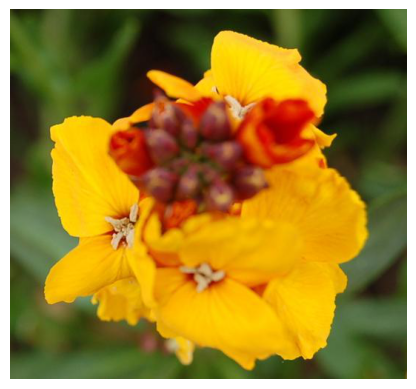

In [118]:
# I use the same query as before(querynum = 1000)
queryimage = io.imread(path + '/' + imagelist[querynum])
plt.imshow(queryimage)
plt.axis('off')
plt.show()

In [119]:
#i use manhattanDistance
distances = np.zeros(len(imagelist))
for i in range(len(imagelist)):
    distances[i] = manhattanDistance(featureTiny[querynum], featureTiny[i])
order = np.argsort(distances)

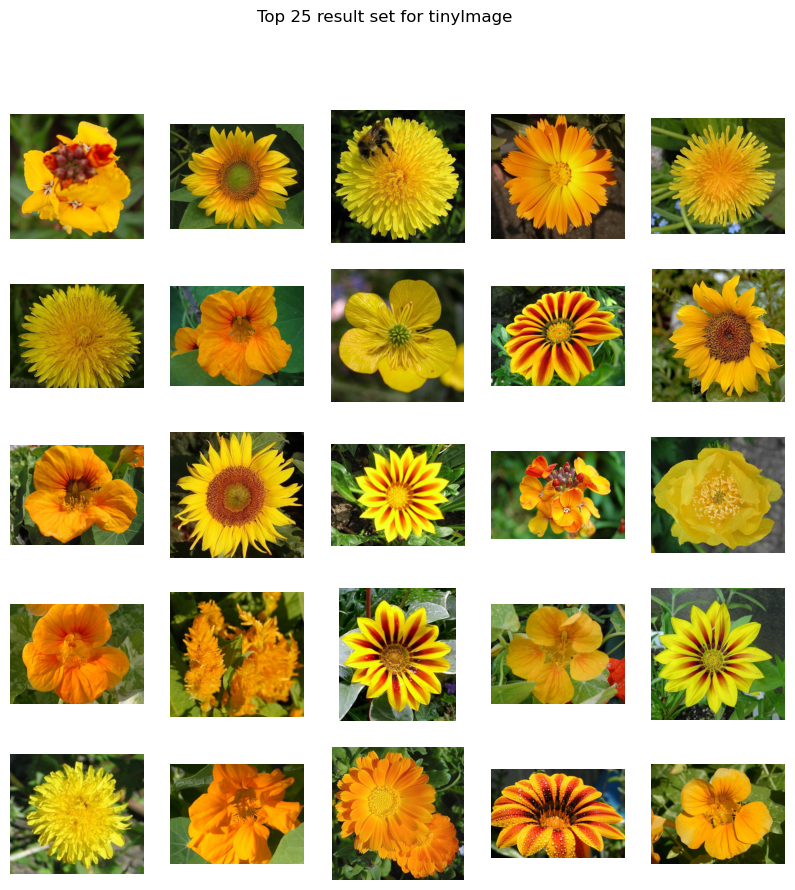

In [120]:
fig = plt.figure(figsize=[10,10])
plt.suptitle('Top 25 result set for tinyImage')
rows = 5 
cols = 5
for i in range(rows*cols):
    image = io.imread(path + '/' + imagelist[order[i]])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()